In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.layers import Activation, Dense, Dropout

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split

In [2]:
# data = pd.read_excel(r"C:\Users\ASUS\Downloads\Finance Distress.xlsx",index_col=0)

xls = pd.ExcelFile(r"C:\Users\ASUS\Downloads\Done.xlsx")


data = pd.read_excel(xls, 'TRAIN',index_col=0)
df2 = pd.read_excel(xls, 'TEST',index_col=0)

In [3]:
data.head()

,EBIT_on_TotalAssets,WorkingCapital_on_TotalAssets,ROA,Debt_to_TotalAssets,CurrentRatio,FirmSize,MarketValue_on_BookValue,ReturnEarnings_on_TotalAssets,TotalAssets_Turnover,Finane_distress
Ticker,,,,,,,,,,
ACL,0.068208,0.622911,0.019832,0.702645,1.026193,6.073741,0.676314,0.014409,1.088106,0
ACL,0.065360,0.601246,0.019623,0.659921,1.044147,6.041248,0.776042,0.001750,1.080085,0
ACL,0.045670,0.747100,0.016983,0.581535,1.368230,6.219988,0.691252,0.233271,0.573506,0
ACM,0.083860,0.251694,0.069874,0.149388,3.559775,5.816057,0.260716,-0.042631,0.422268,0
ACM,0.026325,0.282620,0.012691,0.210324,2.629842,5.834121,0.177636,0.095947,0.184964,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2932 entries, ACL to VTH
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   EBIT_on_TotalAssets            2932 non-null   float64
 1   WorkingCapital_on_TotalAssets  2932 non-null   float64
 2   ROA                            2932 non-null   float64
 3   Debt_to_TotalAssets            2932 non-null   float64
 4   CurrentRatio                   2932 non-null   float64
 5   FirmSize                       2932 non-null   float64
 6   MarketValue_on_BookValue       2932 non-null   float64
 7   ReturnEarnings_on_TotalAssets  2932 non-null   float64
 8   TotalAssets_Turnover           2932 non-null   float64
 9   Finane_distress                2932 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 252.0+ KB


In [5]:
df = data.copy()

In [6]:
# Set the independent variable property
feature = df.columns[df.columns!='Finane_distress'].to_list()
target = [df.columns[-1]]

y = df[target]
X = df[feature]

# Split the train and test
n_state = 42
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7,random_state=n_state)

In [7]:
# Call scale function
sc_X = StandardScaler()
# Scale train set
X_train = sc_X.fit_transform(X_train)
# Scale test set
X_test = sc_X.fit_transform(X_test)

In [8]:
LR_classifier = LogisticRegression()
LR_classifier.fit(X_train, y_train)

y_pred = LR_classifier.predict(X_test)
y_pred = pd.DataFrame(y_pred,index=y_test.index,columns=['Logistic Regression Prediction'])

# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_test,y_pred))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_test,y_pred)}')

# Tỉ lệ chính xác accuracy
print('Logistic Regression accuracy without using stock market news headline: ', round(accuracy_score(y_test, y_pred),4))

Confusion Matrix:
     0    1
0  721   28
1   17  114

Report model:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       749
           1       0.80      0.87      0.84       131

    accuracy                           0.95       880
   macro avg       0.89      0.92      0.90       880
weighted avg       0.95      0.95      0.95       880

Logistic Regression accuracy without using stock market news headline:  0.9489


In [9]:
import statsmodels.api as SM 
table = SM.Logit(y_train,X_train).fit()
print(table.summary())

Optimization terminated successfully.
         Current function value: 0.584555
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        Finane_distress   No. Observations:                 2052
Model:                          Logit   Df Residuals:                     2043
Method:                           MLE   Df Model:                            8
Date:                Fri, 17 Mar 2023   Pseudo R-squ.:                 -0.2885
Time:                        14:54:16   Log-Likelihood:                -1199.5
converged:                       True   LL-Null:                       -930.96
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3460      0.325      1.066      0.287      -0.290       0.982
x2            -0.6033      0.

In [10]:
# Xây dựng mô hình Random Forest
RF_classifier = RandomForestClassifier(random_state=n_state,
                                        n_estimators=1000, 
                                        min_samples_leaf = 2,
                                        max_depth = 15,
                                        criterion="log_loss")
                                        min_samples_split=2)


RF_classifier.fit(X_train, y_train)

# Dự báo giá trị biến phụ thuộc
y_pred = RF_classifier.predict(X_test)
y_pred = pd.DataFrame(y_pred,index=y_test.index,columns=['Random Forest Prediction'])

# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_test,y_pred))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_test,y_pred)}')

# Tỉ lệ chính xác accuracy
print('Random Forest accuracy: ', round(accuracy_score(y_test, y_pred),4))

Confusion Matrix:
     0    1
0  733   16
1   16  115

Report model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       749
           1       0.88      0.88      0.88       131

    accuracy                           0.96       880
   macro avg       0.93      0.93      0.93       880
weighted avg       0.96      0.96      0.96       880

Random Forest accuracy:  0.9636


In [26]:
# train CatBoost model
cat_boost_model = CatBoostClassifier(iterations=100, learning_rate=0.05, loss_function='Logloss',depth=16)
cat_boost_model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6773072	test: 0.6857117	best: 0.6857117 (0)	total: 6.64s	remaining: 10m 57s
1:	learn: 0.6626071	test: 0.6781940	best: 0.6781940 (1)	total: 9.92s	remaining: 8m 6s
2:	learn: 0.6456466	test: 0.6697325	best: 0.6697325 (2)	total: 13.6s	remaining: 7m 20s
3:	learn: 0.6252220	test: 0.6501202	best: 0.6501202 (3)	total: 13.8s	remaining: 5m 31s
4:	learn: 0.6060817	test: 0.6349916	best: 0.6349916 (4)	total: 17.1s	remaining: 5m 25s
5:	learn: 0.5947429	test: 0.6247305	best: 0.6247305 (5)	total: 20.3s	remaining: 5m 17s
6:	learn: 0.5815865	test: 0.6186419	best: 0.6186419 (6)	total: 23.3s	remaining: 5m 10s
7:	learn: 0.5656712	test: 0.6079623	best: 0.6079623 (7)	total: 26.4s	remaining: 5m 3s
8:	learn: 0.5536575	test: 0.6000479	best: 0.6000479 (8)	total: 29.2s	remaining: 4m 55s
9:	learn: 0.5427062	test: 0.5916355	best: 0.5916355 (9)	total: 32.3s	remaining: 4m 50s
10:	learn: 0.5329586	test: 0.5824216	best: 0.5824216 (10)	total: 35.2s	remaining: 4m 44s
11:	learn: 0.5210498	test: 0.5707245	best:

In [27]:
y_pred_cat = cat_boost_model.predict(X_test)
# y_pred = pd.DataFrame(y_pred, columns=["predictions"],index=y_test.index)

# evaluate model
train_score = cat_boost_model.score(X_train, y_train)
print('Train accuracy:', train_score)

test_score = cat_boost_model.score(X_test, y_test)
print('Test accuracy:', test_score)

# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_test,y_pred_cat))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_test,y_pred_cat)}')

# Tỉ lệ chính xác accuracy
print('Catboost model accuracy:', round(accuracy_score(y_test, y_pred_cat),4))

Train accuracy: 0.9926900584795322
Test accuracy: 0.9613636363636363
Confusion Matrix:
     0    1
0  732   17
1   17  114

Report model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       749
           1       0.87      0.87      0.87       131

    accuracy                           0.96       880
   macro avg       0.92      0.92      0.92       880
weighted avg       0.96      0.96      0.96       880

Catboost model accuracy: 0.9614


In [25]:
classifier_svm = SVC(kernel = 'rbf', probability=True, random_state = n_state)
classifier_svm.fit(X_train, y_train)

y_pred = classifier_svm.predict(X_test)

y_pred = pd.DataFrame(y_pred,columns=["predictions"])

print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test,y_pred)),'\n')

print('Classification report:')
print(classification_report(y_test,y_pred))

print('Support Vector Machine "RBF Kernel" accuracy:', round(accuracy_score(y_test, y_pred),4))

Confusion matrix:
     0    1
0  732   17
1   19  112 

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       749
           1       0.87      0.85      0.86       131

    accuracy                           0.96       880
   macro avg       0.92      0.92      0.92       880
weighted avg       0.96      0.96      0.96       880

Support Vector Machine "RBF Kernel" accuracy: 0.9591


In [13]:
classifier_svm_lr = SVC(kernel = 'linear', probability=True, random_state = n_state)
classifier_svm_lr.fit(X_train, y_train)

y_pred_lr = classifier_svm_lr.predict(X_test)

print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test,y_pred_lr)),'\n')

print('Classification report:')
print(classification_report(y_test,y_pred_lr))

print('Support Vector Machine "Linear Kernel" accuracy:', round(accuracy_score(y_test, y_pred_lr),4))

Confusion matrix:
     0    1
0  716   33
1   16  115 

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       749
           1       0.78      0.88      0.82       131

    accuracy                           0.94       880
   macro avg       0.88      0.92      0.90       880
weighted avg       0.95      0.94      0.95       880

Support Vector Machine "Linear Kernel" accuracy: 0.9443


In [24]:
classifier_svm_poly = SVC(kernel = 'poly', probability=True, random_state = n_state)
classifier_svm_poly.fit(X_train, y_train)

y_pred_poly = classifier_svm_poly.predict(X_test)

y_pred_poly = pd.DataFrame(y_pred_poly,columns=["predictions"])

print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test,y_pred_poly)),'\n')

print('Classification report:')
print(classification_report(y_test,y_pred_poly))

print('Support Vector Machine "Poly Kernel" accuracy:', round(accuracy_score(y_test, y_pred_poly),4))

Confusion matrix:
     0    1
0  737   12
1   30  101 

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       749
           1       0.89      0.77      0.83       131

    accuracy                           0.95       880
   macro avg       0.93      0.88      0.90       880
weighted avg       0.95      0.95      0.95       880

Support Vector Machine "Poly Kernel" accuracy: 0.9523


In [15]:
import shap
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(cat_boost_model)
shap_values = explainer.shap_values(X_test)

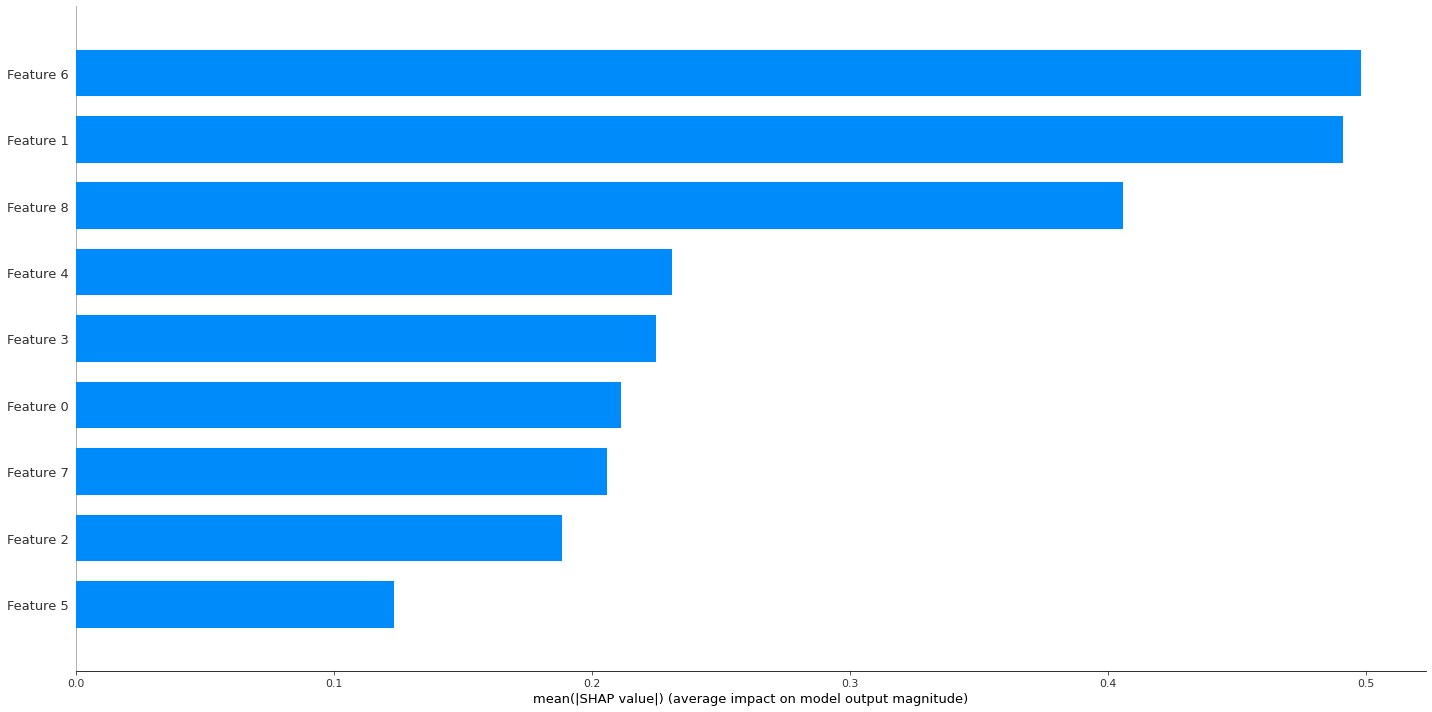

In [16]:
# Bar chart
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False,plot_size = [20,10])

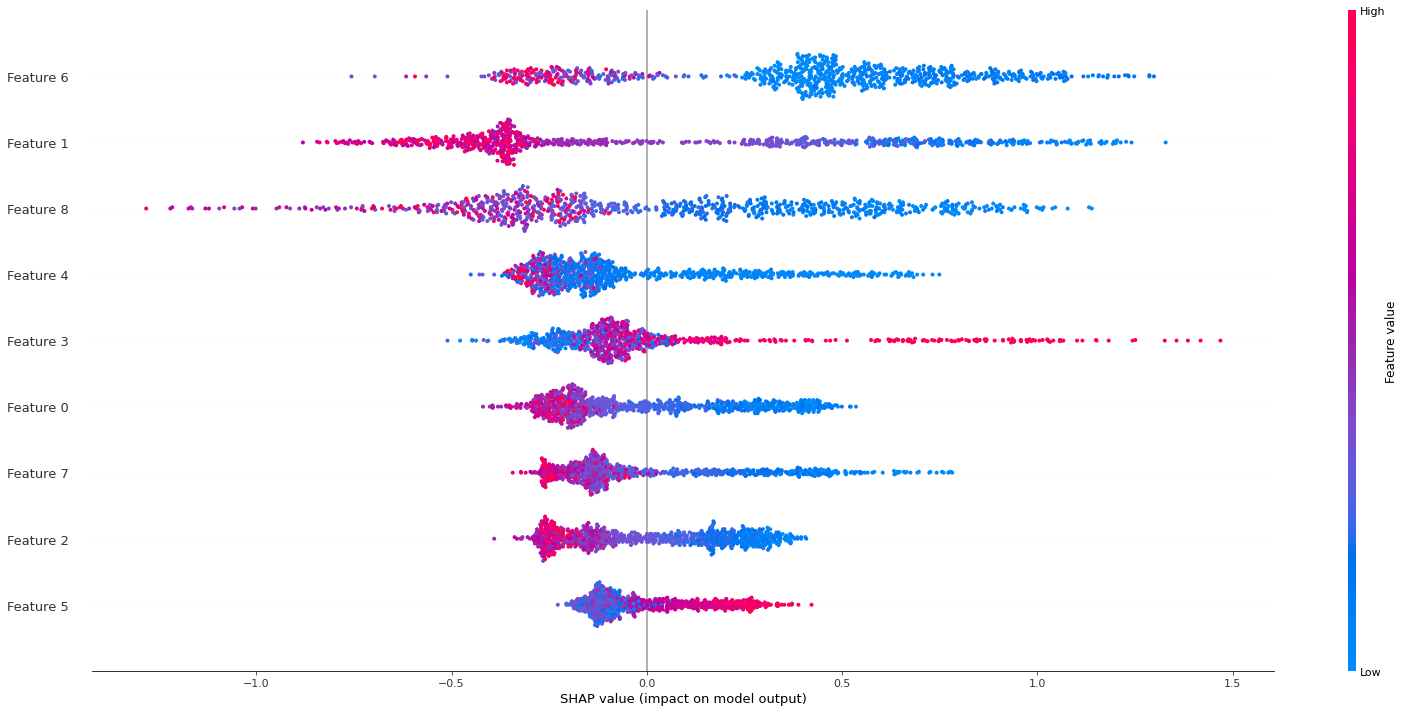

In [17]:
# a density scatter plot
shap.summary_plot(shap_values, X_test,plot_size = [22,10])


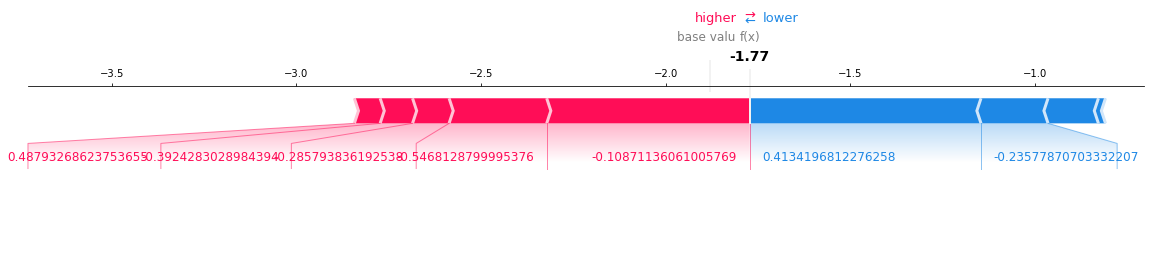

In [18]:
# load Javascript library for visualization in notebook
shap.initjs()

# plot and save the image for the report
def shap_indiv_plot(m):
 return shap.force_plot(explainer.expected_value, shap_values[m], X_test[m],show=False,matplotlib=True).savefig('Shap_plot_03.png', bbox_inches='tight')

# plot the Shap values for the 9th data point/borrower in the dataset, for example
shap_indiv_plot(0)

In [19]:
df2

,EBIT_on_TotalAssets,WorkingCapital_on_TotalAssets,ROA,Debt_to_TotalAssets,CurrentRatio,FirmSize,MarketValue_on_BookValue,ReturnEarnings_on_TotalAssets,TotalAssets_Turnover,Finane_distress
Ticker,,,,,,,,,,
AAA,0.038204,0.431383,0.020744,0.580775,1.606347,6.291094,0.549380,0.061048,0.825956,0
AAA,0.062997,0.332126,0.046440,0.689775,1.194128,6.488214,0.338109,-0.001584,0.696568,0
AAA,0.089299,0.342995,0.057551,0.644905,1.076307,6.660501,0.356928,0.004593,0.889307,0
AAA,0.050466,0.435064,0.028177,0.604173,1.244305,6.876747,0.474205,0.037358,1.064072,0
AAA,0.103013,0.517662,0.061475,0.592456,1.535962,6.902408,0.455837,-0.015609,1.159077,0
...,...,...,...,...,...,...,...,...,...,...
WCS,0.298902,0.771204,0.238246,0.165982,6.114068,5.370957,10.802459,0.078866,0.507559,0
WCS,0.271081,0.793569,0.215952,0.150226,6.871783,5.452229,9.898392,0.082678,0.450351,0
WCS,0.253617,0.830871,0.202488,0.116072,9.077995,5.516364,11.052251,0.075983,0.403182,0


In [20]:
df_new = df2.copy()

# Set the independent variable property
feature_new = df_new.columns[df_new.columns!='Finane_distress'].to_list()
target_new =  [df_new.columns[-1]]

y_new = df_new[target_new]
X_new = df_new[feature_new]

sc_X_new = StandardScaler()
# Scale train set
X_new = sc_X_new.fit_transform(X_new)

In [ ]:
y_pred_svm_lr = classifier_svm_lr.predict(X_new)

# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_new,y_pred_svm_lr))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_new,y_pred_svm_lr)}')

# Tỉ lệ chính xác accuracy
print('Random Forest accuracy: ', round(accuracy_score(y_new, y_pred_svm_lr),4))

In [29]:
# Dự báo giá trị biến phụ thuộc
y_new_pred_rf = RF_classifier.predict(X_new)


# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_new,y_new_pred_rf))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_new,y_new_pred_rf)}')

# Tỉ lệ chính xác accuracy
print('Random Forest accuracy: ', round(accuracy_score(y_new, y_new_pred_rf),4))

Confusion Matrix:
    0  1
0  80  7
1   2  9

Report model:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        87
           1       0.56      0.82      0.67        11

    accuracy                           0.91        98
   macro avg       0.77      0.87      0.81        98
weighted avg       0.93      0.91      0.92        98

Random Forest accuracy:  0.9082


In [28]:
# Dự báo giá trị biến phụ thuộc
y_new_pred_catboost = cat_boost_model.predict(X_new)
# y_pred = pd.DataFrame(y_pred,index=y_test.index,columns=['Catboost Prediction'])

# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_new,y_new_pred_catboost))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_new,y_new_pred_catboost)}')

# Tỉ lệ chính xác accuracy
print('Random Forest accuracy: ', round(accuracy_score(y_new, y_new_pred_catboost),4))

Confusion Matrix:
    0  1
0  79  8
1   2  9

Report model:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        87
           1       0.53      0.82      0.64        11

    accuracy                           0.90        98
   macro avg       0.75      0.86      0.79        98
weighted avg       0.93      0.90      0.91        98

Random Forest accuracy:  0.898
